
<div align="center"><img 
src='https://1000logos.net/cisco-logo/.jpg'/
>


<div align="center"><img src='https://bestfriends.org/sites/default/files/styles/max_650x650/public/partners/Austin%20Animal%20Center.jpg'/>

<h1 style="color:#900C3F;font:luminary;text-align:center;"><i>Cisco Project</i></h1>



<h2 style="color:#900C3F;">Project's Goal</h2> 

This team was tasked to build a model that can predict the sales for Cisco in 2023.

<h2 style="color:#900C3F;">Project's Description</h1> 

<div class=“alert alert-success”>

Our goal is to explore historical cisco sales to Texas public agencies (school districts, government agencies, municipalities, etc) to present to people who might want to buy into the cisco ecosystem if it is a good idea going forward. This can include potential stock investors or customers or even people looking to train to properly implement Cisco equipment. Assessing Cisco’s strength selling in the state can assure potential buy-in for all those parties. Included in this information will be projected sales a year in the future, with additional 2 and 5 year forecasts.
</div>

In [1]:
# imports
import pandas as pd
import src.wrangle as wr
import src.summaries as s
from importlib import reload
import numpy as np

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format

<h3 style="color:#900C3F;">Acquire</h3> 

- Data acquired from 
- Data contains 
- Each row represents a 
- Each column represents


<h3 style="color:#900C3F;">Prepare</h3> 

- As a first step of the exploration we divided the data into three data sets: train, validate and test to adoid data leakage.
- The target variable of the project is ```purchase_amount```
- null values
- 2017....
- dropped....


In [2]:
# Acquire data and prep data
df = wr.get_clean_data(start2018=True)

In [4]:
# train/test split
train, test = wr.split_data(df)

<h3 style="color:#900C3F;">Data Dictionary</h3> 

| Feature | Description|
|:---|:---|
|abc| abc|

For statistical tests:

- $H_0:$ stands for 'Null hypothesis’ 
- $H_a:$ stands for 'Alternative hypotheses'

- All statistical tests run for the **95% Confidence level**.
- The **significance level** (alpha) is set to **0.05**
- If the p-value is smaller than 0.05 we reject the Null hypothesis.

### 1. Is there any significant difference in sales by the day of the week?

In [6]:
# order for graphs
months =['January', 'February', 'March', 'April', 'May', 
         'June', 'July', 'August', 'September', 'October', 'November', 'December']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

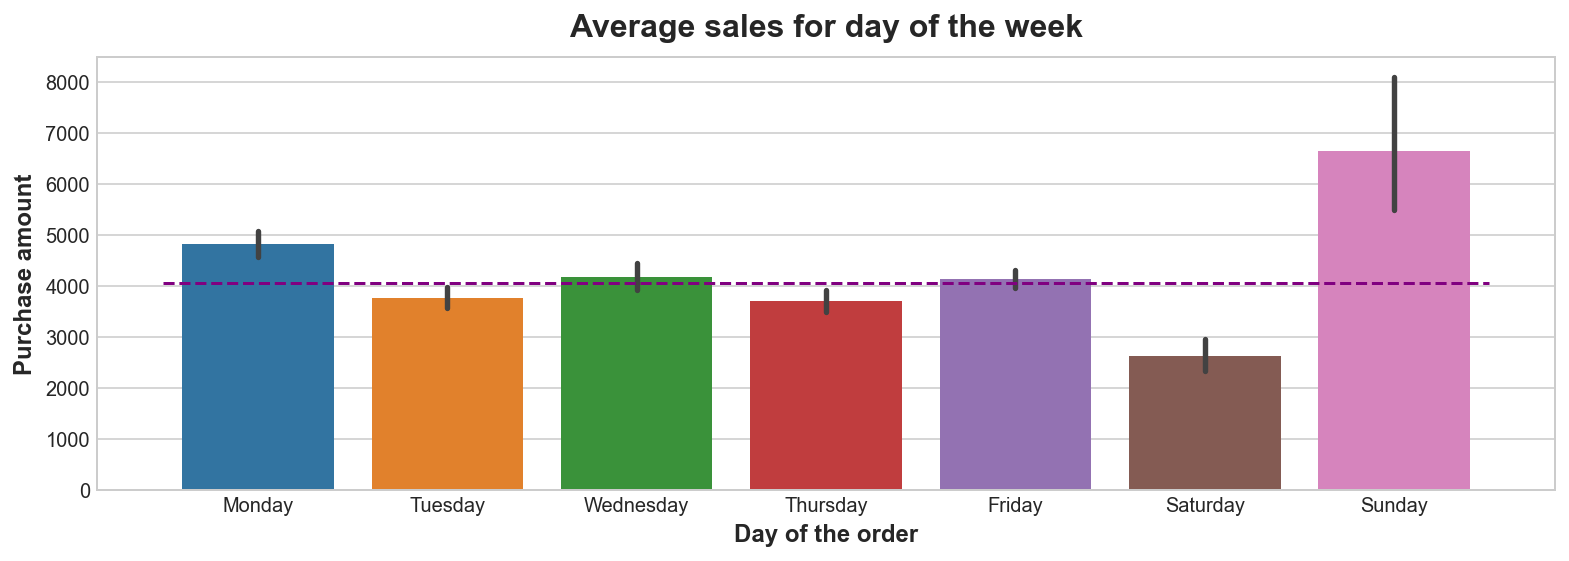

In [7]:
# visualize 
ax = sns.barplot(data = train, x='day_name', y='purchase_amount', order=days)
plt.xlabel('Day of the order')
plt.ylabel('Purchase amount')
x_left, x_right = ax.get_xlim()
ax.hlines(train.purchase_amount.mean(), x_left, x_right, ls='--', color='purple')
plt.title('Average sales for day of the week')
plt.show()


There is an unexpected peak of average purchase_amount on Sunday. Since the goverment insitutions don't work on Sunday, it might be when resellers put their orders right before Monday. The graph also shows big variance in the values on Sunday. I'm going to create sets for each day to run stat tests.

In [8]:
mon = train[train.day_name == 'Monday']
tue = train[train.day_name == 'Tuesday']
wed = train[train.day_name == 'Wednesday']
thu = train[train.day_name == 'Thursday']
fri = train[train.day_name == 'Friday']
sat = train[train.day_name == 'Saturday']
sun = train[train.day_name == 'Sunday']

Mon-Fri seem to be almost equal, let's run stat tests

$H_0$: There is a significant difference in means of purchase amount during work days (Mon-Fri)


$H_a$: There is no significant difference in means of purchase amount during work days (Mon-Fri)

In [9]:
stats.levene(mon.purchase_amount, tue.purchase_amount, wed.purchase_amount, thu.purchase_amount, fri.purchase_amount)

LeveneResult(statistic=12.250230257226312, pvalue=5.850300040031373e-10)

In [10]:
stats.kruskal(mon.purchase_amount, tue.purchase_amount, wed.purchase_amount, thu.purchase_amount, fri.purchase_amount)

KruskalResult(statistic=1197.6600345778163, pvalue=5.12219477460496e-258)

In [12]:

days_of_week = {'Monday':mon, 'Tuesday':tue, 'Wednesday':wed, 'Thursday':thu, 
                'Friday':fri, 'Saturday':sat, 'Sunday':sun}
ttest_results_days = pd.DataFrame(columns=['Day', 'T-value', 'P-value'])
for day in days_of_week:
    sale = days_of_week[day]['purchase_amount']
    t, p = stats.ttest_1samp(sale, train.purchase_amount.mean())
    ttest_results_days.loc[len(ttest_results_days)] = [day, t, p]
ttest_results_days.set_index('Day', inplace=True)

In [13]:
ttest_results_days

,T-value,P-value
Day,,
Monday,5.61,0.00
Tuesday,-2.92,0.00
Wednesday,0.88,0.38
Thursday,-3.37,0.00
Friday,0.74,0.46
Saturday,-9.17,0.00
Sunday,3.85,0.00


### Takeaway:
Monday, Tuesday, Thursday, Saturday, Sunday are significant

### 2. Is there any significant difference in sales by the month?

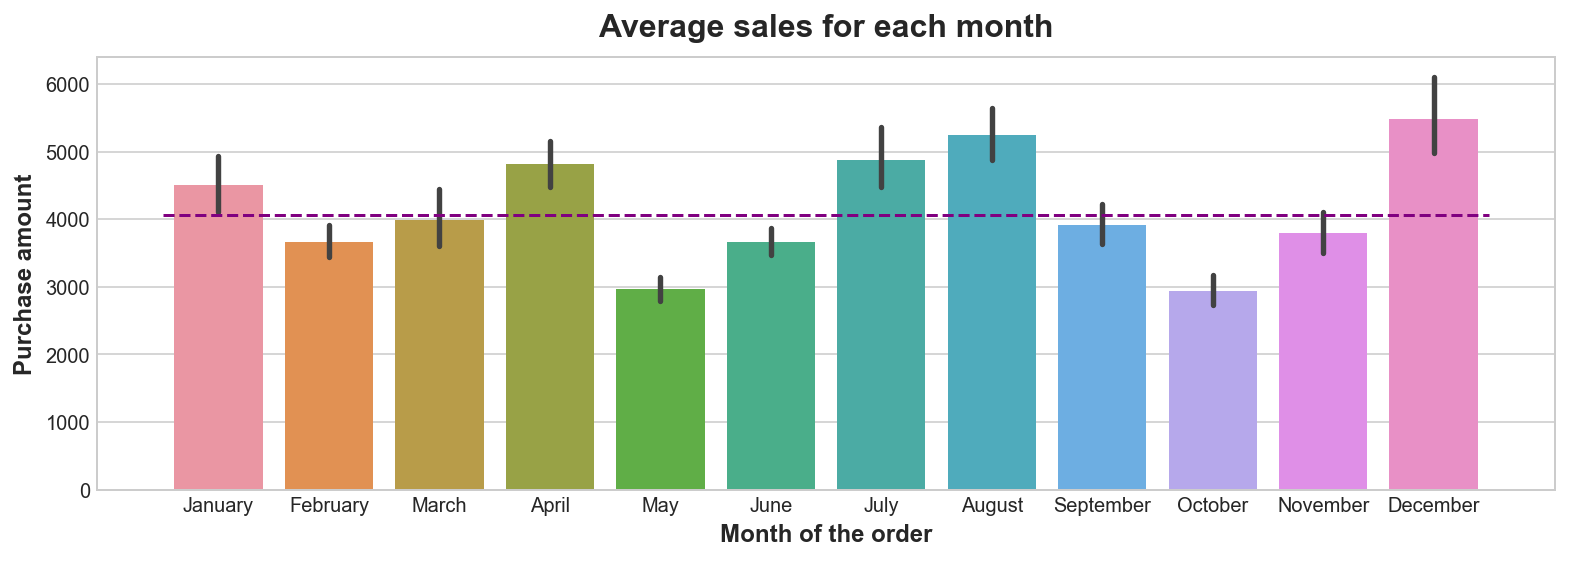

In [15]:
# visualize 
ax = sns.barplot(data=train, x='month_name', y='purchase_amount')
plt.xlabel('Month of the order')
plt.ylabel('Purchase amount')
x_left, x_right = ax.get_xlim()
ax.hlines(train.purchase_amount.mean(), x_left, x_right, ls='--', color='purple')
plt.title('Average sales for each month')
plt.show()

abc...

In [16]:
ttest_results_months = pd.DataFrame(columns=['Month', 'T-value', 'P-value'])
for m in months:
    month = train[train.month_name == m]['purchase_amount']
    t, p = stats.ttest_1samp(month, train.purchase_amount.mean())
    ttest_results_months.loc[len(ttest_results_months)] = [m, t, p]
ttest_results_months.set_index('Month', inplace=True)

In [17]:
ttest_results_months

,T-value,P-value
Month,,
January,2.05,0.04
February,-3.20,0.00
March,-0.30,0.76
April,4.34,0.00
May,-12.84,0.00
June,-3.70,0.00
July,3.82,0.00
August,5.83,0.00
September,-0.92,0.36


### Takeaways:
- Some months are significantly different in sales
- May and October are the months with the lowest sales
- March has almost the same results as average sales, but there was peak in sales on March, 2020 when pandemic just started, it might happened that March is typically low on sales, too

### 3. Is there any significant difference in sales by the quarter?

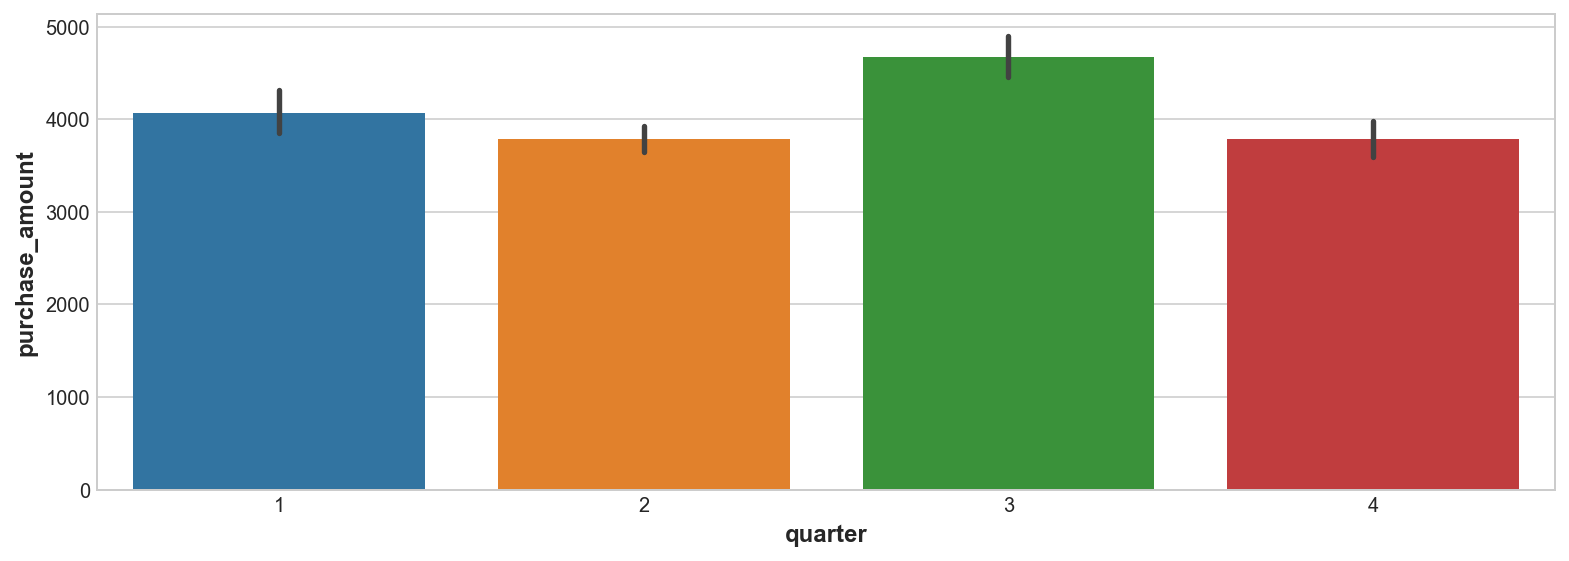

In [18]:
# Plot the crashes where alcohol was involved
#sns.set_color_codes("muted")
ax = sns.barplot(x="quarter", y="purchase_amount", data=train)

...abc

In [19]:
ttest_results_quarters = pd.DataFrame(columns=['Quarter', 'T-value', 'P-value'])
for i in range(1, 5):
    q = train[train.quarter == i]['purchase_amount']
    t, p = stats.ttest_1samp(q, train.purchase_amount.mean())
    ttest_results_quarters.loc[len(ttest_results_quarters)] = [i, t, p]
ttest_results_quarters.set_index('Quarter', inplace=True)

In [20]:
ttest_results_quarters

,T-value,P-value
Quarter,,
1.00,0.07,0.94
2.00,-3.74,0.00
3.00,5.27,0.00
4.00,-2.82,0.00


### Takeaways:
abc

### 4. Is there any significant change in monthly sales percentage in our data?

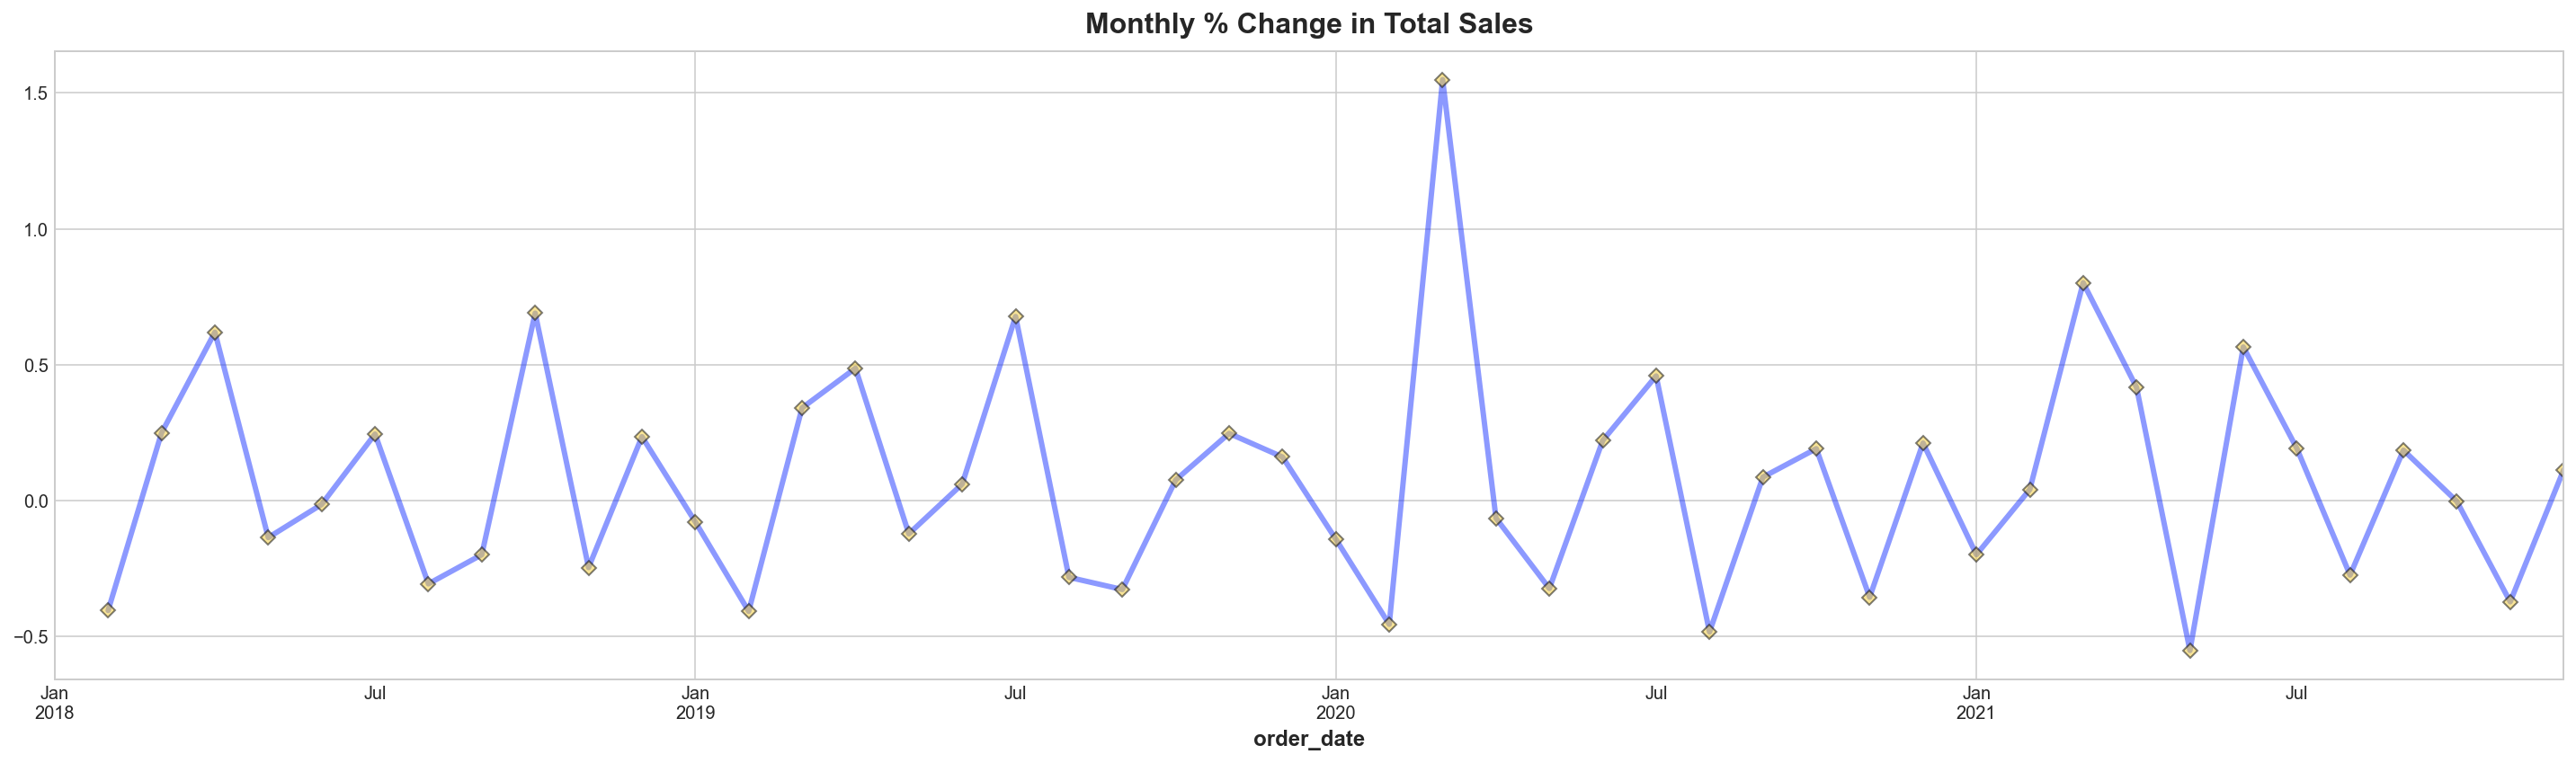

In [30]:
# time series variable
ts = train.purchase_amount
y_month = ts.resample('M').sum()
plt.figure(figsize = (20, 6))
(y_month.diff() / y_month.shift()).plot(alpha=.5, lw=3, c='#1a34ff', 
                                      marker='D', mfc='#f2cb30',mec='black', title='Monthly % Change in Total Sales');

### Takeaway:
In the beginning of the pandemic there was a spike in sales.

### 5. What are the trends in sales with school districts as a subgroup (seasonality)?

In [32]:
def create_customertype_subgroups(train):
    
    types = train[['purchase_amount','customer_type']]
    k_12= types[types["customer_type"]=='K-12']
    local_gov = types[types["customer_type"]=='Local Government']
    state_agency = types[types["customer_type"]=='State Agency']
    higher_ed = types[types["customer_type"]=='Higher Ed']
    other = types[(types['customer_type']=='Assistance Org') | (types['customer_type']=="Other")]
    
    return k_12, local_gov, state_agency, higher_ed, other

In [33]:
def get_timeseries_plus(df):
    print(pd.plotting.autocorrelation_plot(df.resample('W').mean()))
    print (df.groupby([df.index.year, df.index.month]).mean().unstack(0).plot())
    print(df.groupby([df.index.year, df.index.day]).mean().unstack(0).plot())
    y = df.resample('W').mean()

    result = sm.tsa.seasonal_decompose(y)
    print(result.plot())

In [37]:
def get_seasonality(df):
    '''
    get seasonality takes a dataframe with date as index and prints out seasonalty results
    '''
    y = df.resample('W').mean()

    result = sm.tsa.seasonal_decompose(y)
    print(result.plot())

In [35]:
k_12, local_gov, state_agency, higher_ed, other = create_customertype_subgroups(train)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
Figure(792x288)


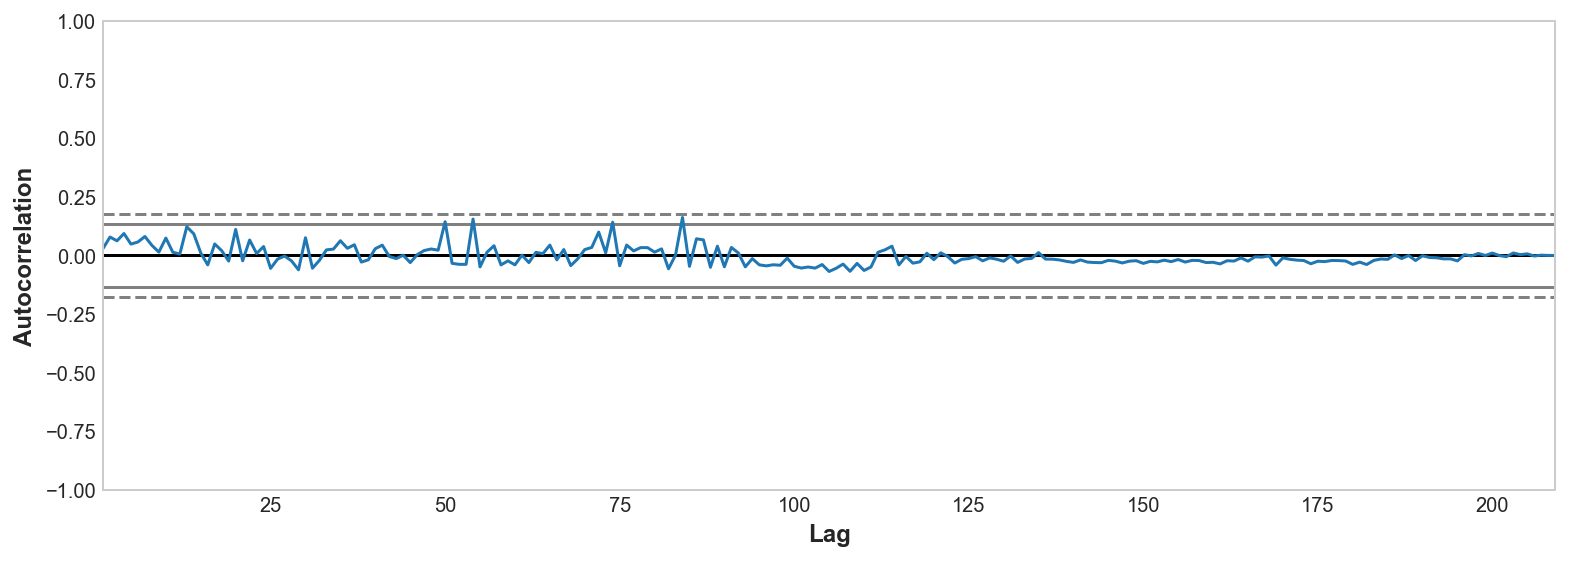

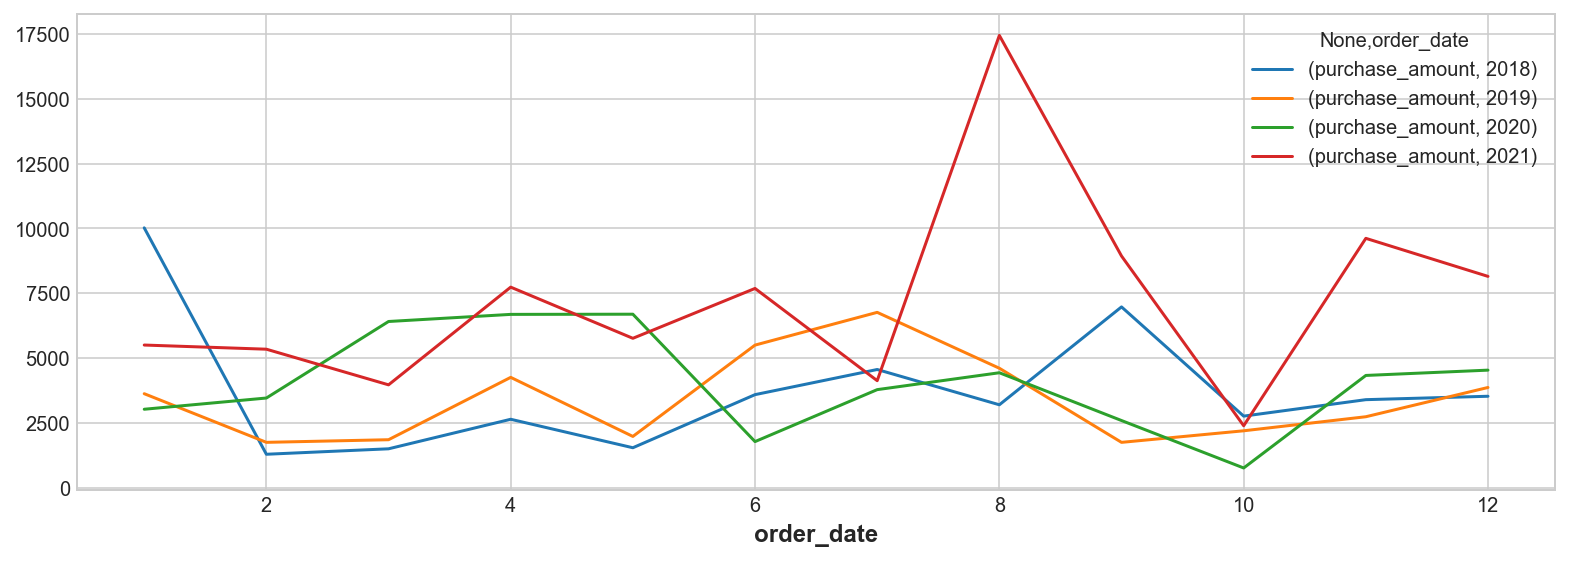

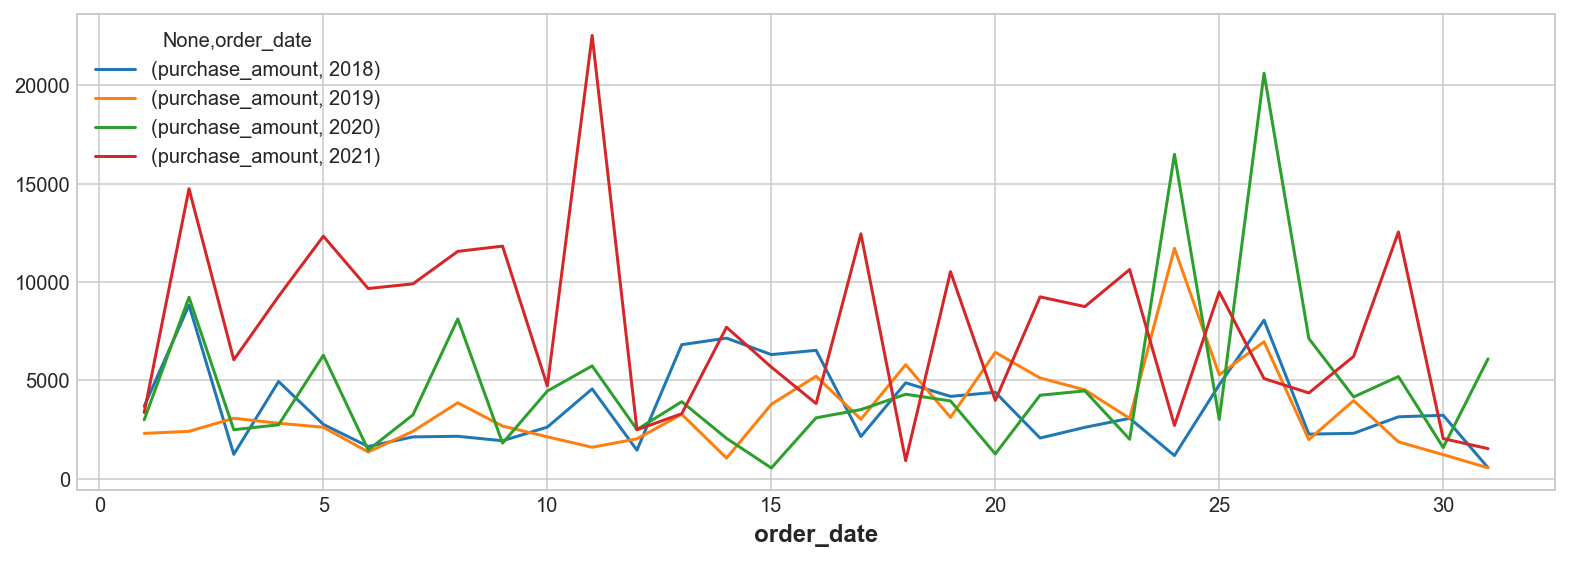

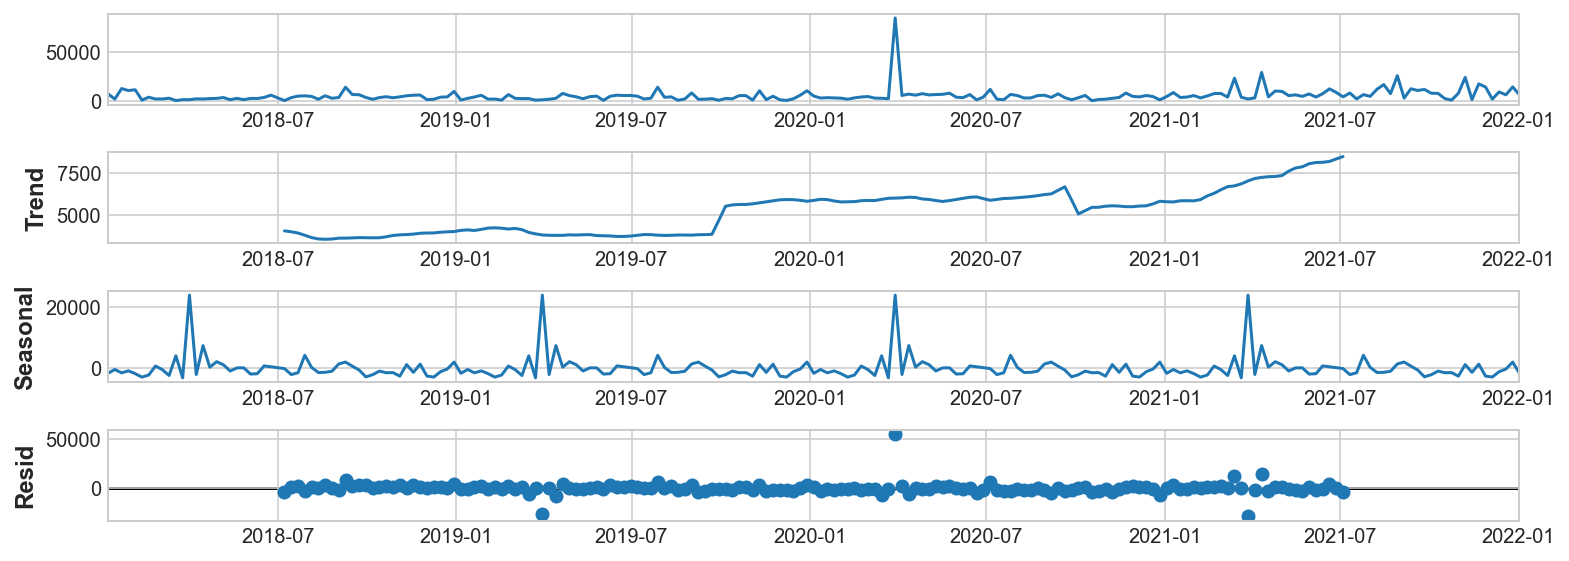

In [36]:
get_timeseries_plus(k_12)

Figure(792x288)


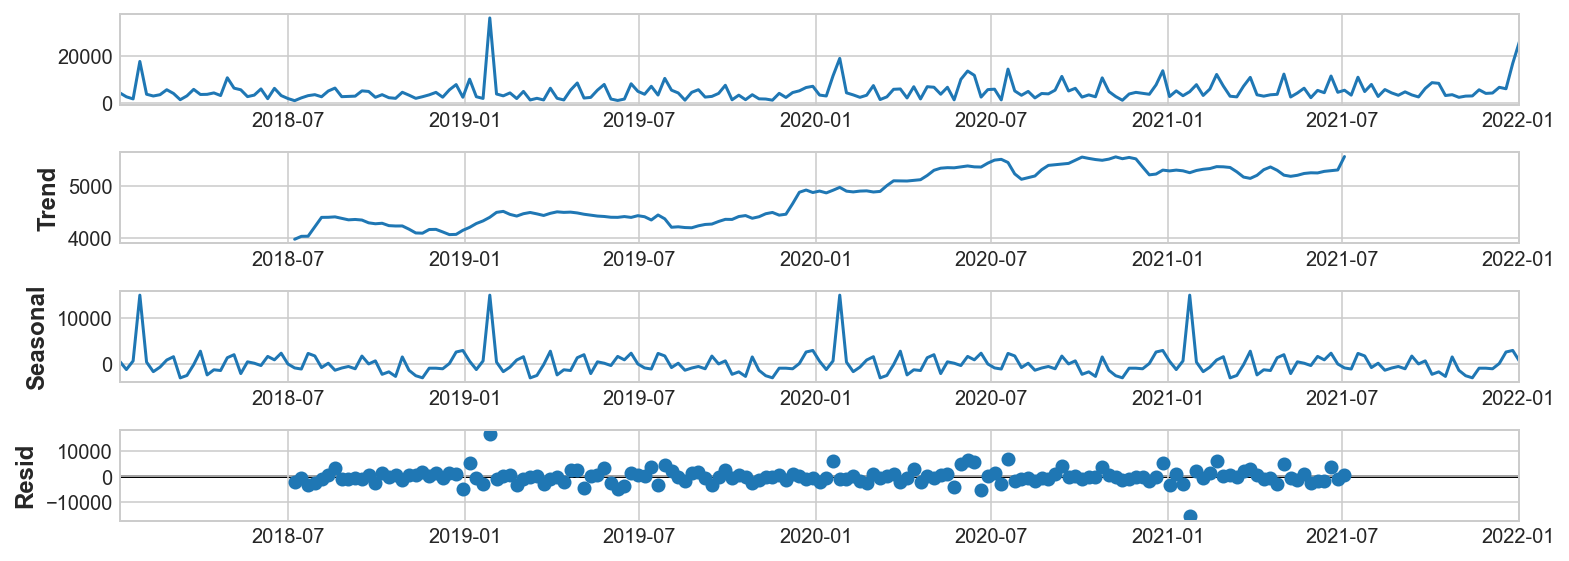

In [39]:
get_seasonality(local_gov)

Figure(792x288)


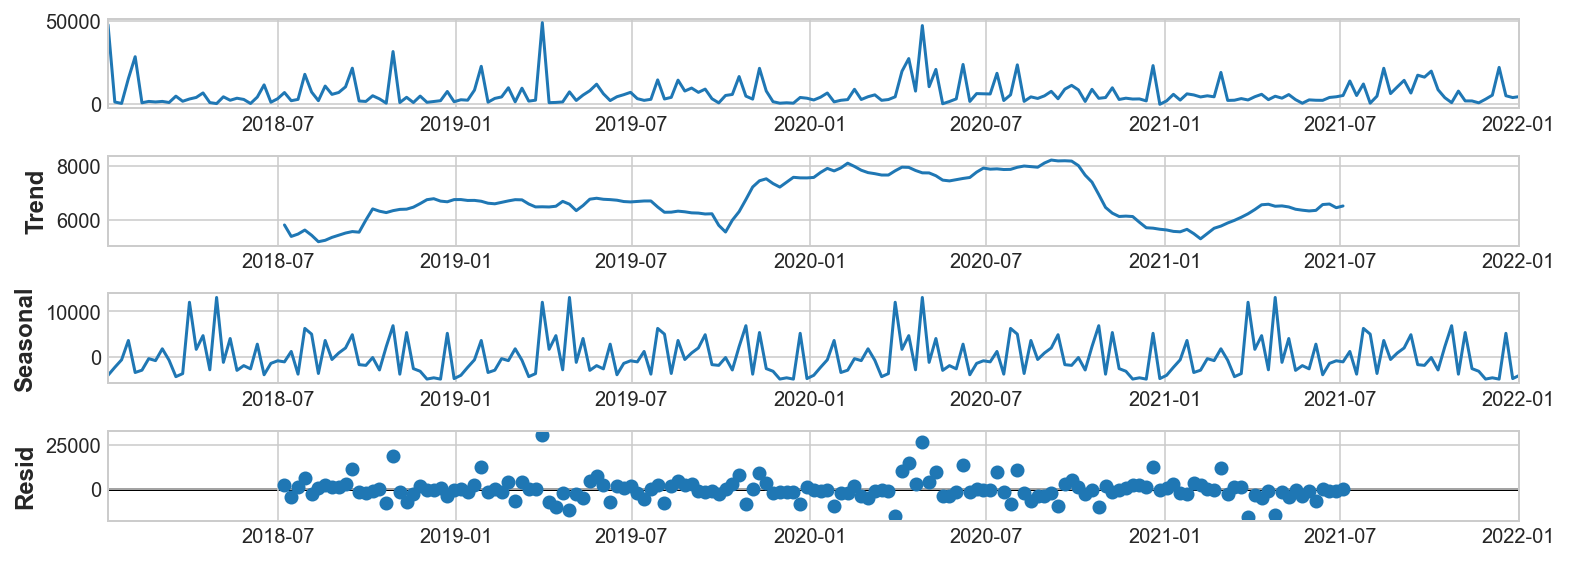

In [40]:
get_seasonality(state_agency)

Figure(792x288)


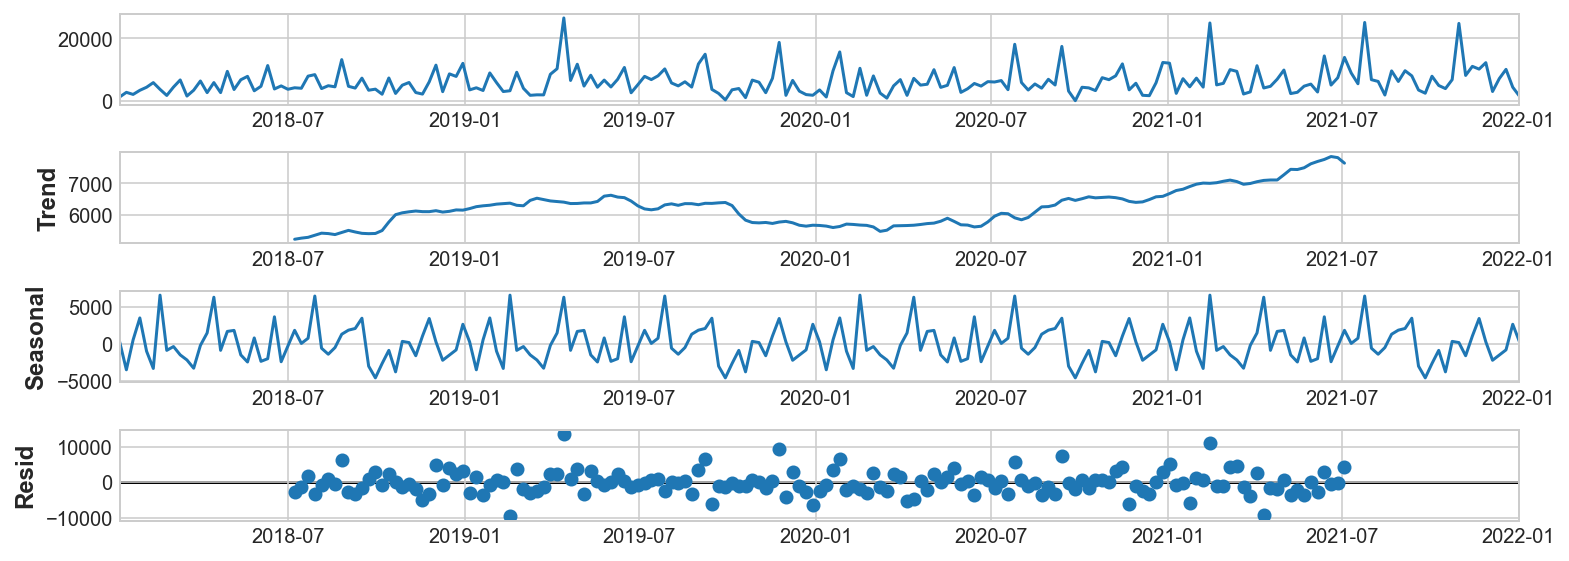

In [41]:
get_seasonality(higher_ed)

####
#get_seasonality(other)
other does not have seasonality 

### Takeaway:
There is seasonality in the following subgroups k_12, local_gov, state_agency, higher_ed. The subgroup classified as other does seasonality can not be determined due to null values.

### 4. ....chirs

In [26]:
orders_summary = s.get_summary_orders_df(train)
sales_summary = s.get_summary_df(train)

In [27]:
thhsc = pd.concat([
    orders_summary[orders_summary.customer_name == 'Texas Health and Human Services Commission'],
    sales_summary[sales_summary.customer_name == 'Texas Health and Human Services Commission'].purchase_amount
],axis=1)

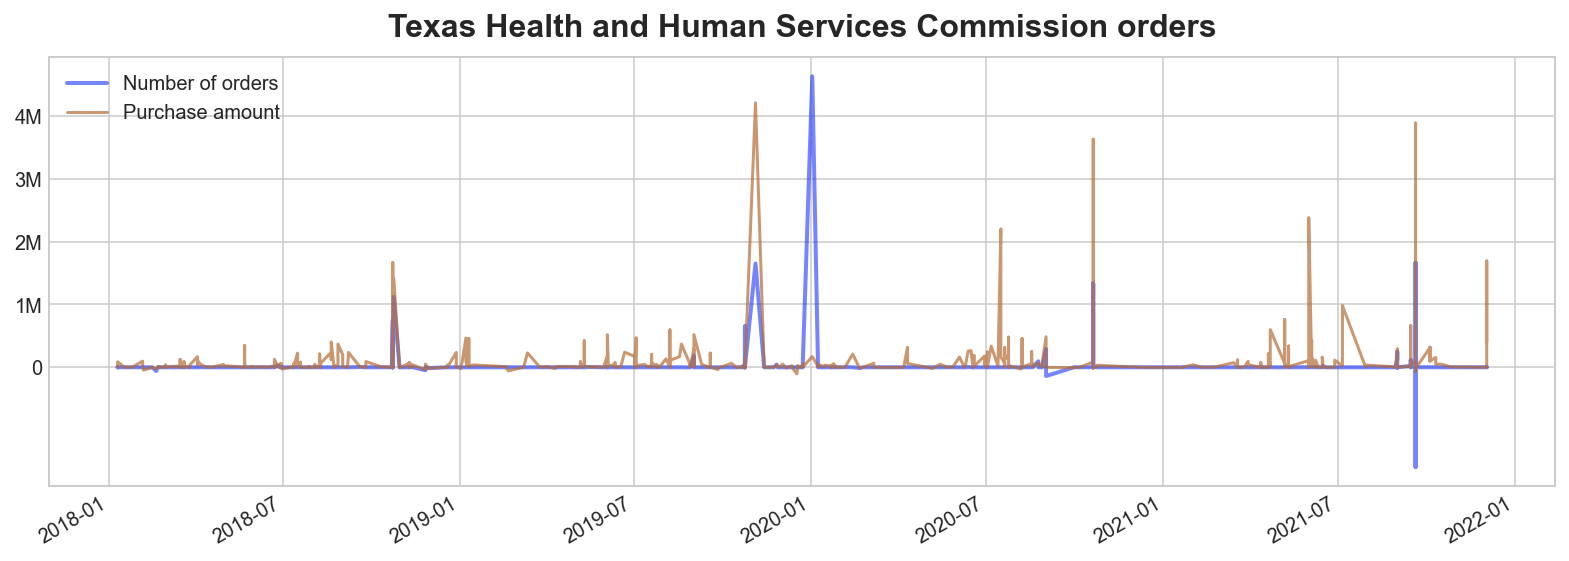

In [28]:
#ax, _ = plt.subplots(figsize=(18,6))
ax = thhsc.order_quantity.plot(label='Number of orders', lw=2, c='#1a34ff', alpha=0.6)
ax = thhsc.purchase_amount.plot(label='Purchase amount', lw=1.5, c='#b56b35', alpha=0.7)
plt.title('Texas Health and Human Services Commission orders')
ax.set(yticks=[0, 1_000_000, 2_000_000, 3_000_000, 4_000_000])
ax.set(yticklabels=['0', '1M', '2M', '3M', '4M'])
ax.set(xlabel=None)
plt.legend()
plt.show()

<h3 style="color:#900C3F;">Exploration Takeaways</h3> 

 - Almost 70% of animals are adopted, around 26% are transfered to other facilities, 2.5% of animals are euthanized and less than 1% die of natural causes.
 - The outcome type has an association with the animal type. Animals other than cats, dogs, or rabbits get euthanized much more often, and cats/dogs are euthanized more often than rabbits.
 - Intact animals have much lower chances to be adopted.
 - Despite the distribution of outcomes for males and females look relatively the same, the statistical test shows that the sex plays a significant role in the outcome. It might happen because of 'Unknown' sex group.
 - Older animals have higher chances to be euthanized while very young animals die more from natural causes.
 - There is a significant difference in means between the age on the check-in and overall mean among different outcomes.
 - There is a significant difference in means of the ```age_on_check_in``` among all outcome groups.
 - Beeing an old cat or an old guinea pig dramatically increase the chance of the euthanasia for an animal. While wild animals have almost equal chances to be adopted, transfered, euthanized or die not depending on their age.

<h3 style="color:#900C3F;">Modeling</h3> 

To prepare the data set for modeling we:

- digitized the categorical data
- removed the features that are not useful for predictions (see the table below)
- separated the target variable from the train, validate and test data sets.

#### Features to drop before modeling

|Feature|The reason|
|:------|:-------|
|<img width=150/>|<img width=450/>|
|*animal_id*| id number|
|*name*|not suitable for modeling|
|*first_check_in*| value passed to ```days_at_shelter```|
|*last_check_out*| value passed to ```days_at_shelter```|
|*age_in_years*|not significant for the prediction of natural death|
|*age_in_month*|lower significance that ```age_in_days```|
|*date_of_birth*|date type, used to create age features|
|*first_check_in*|date type, used to create age features|
|*last_check_out*|date type, used to create age features|
|*sex*|used to create ```sex_of_animal``` and ```sterilized``` features|
|*color*|too many categorical values|
|*outcome_subtype*|is ```outcome_type``` description|

All other features will go into the train, validate and test data sets. The column ```breed``` contains too many categorical values. I created dummy variables only for some of them.

**How I create models**

I use 3 different classifiers (classification algorithms): 
- Decision Tree, 
- Random Forest, 
- Logistic Regression. 

For the first 2 of them, I use different hyperparameters. For Logistic regression I transform numerical values with Quantile Transformer. 

To run my models I use two different iterations. The first one takes only the data obtained from ```Austin_Animal_Center_Intakes.csv``` file. I will check if it is possible predict the outcome based on exclusively intake data. For the second iteretion I use all features from the intake data and the data of outcomes ```Austin_Animal_Center_Outcomes.csv```. The source of files is mentioned in the Readme file of the project.

### Data evaluation

To evaluate the model performance I use the accuracy score. My baseline the most popular outcome's percentage. It is 70%. 

In [ ]:
# show the baseline value
md.baseline

Every classifier runs in a function where it creates models in a ```for``` loop. This loop iterates through the features and in some cases through the hyperparameters as well. After the iterations, the function returns a ```DataFrame``` that contains only 2 models from each classifier. Those are the models that obtained the best accuracy on the train set. 

The next function calculates the difference between the train and validate scores and returns the 3 best models (sorted by maximum ```validate_score``` and minimum score difference ```diff```)


First let's see three models that performed best on the training set with **intake** data.

In [ ]:
# show the best performing models for the Intake data iteretion
md.best_results_intake()

All *winning* models beat the baseline by 10%

The Random Forest model that doesn't contain any information has worse results on the validation set.

The results of models with the data from both **intake** and **outcome** data sets.

In [ ]:
# show the best performing models for the iteration of intake and outcome features 
md.best_results_whole()

Adding additional features slightly improved the model's performance. Despite the features with the complete data imporove the performance, for the my final test I pick the **Random Forest Classifier** with intake only features, as it is more usefull for the real world. We are more interested in knowing right away the possible outcome for every animal and work on prevention the death or euthanasia.

In [ ]:
# show the model's performance on the test data set.
md.run_best_model()

The performace dropped slightly although the model still beats the baseline by more than 10%

#### Modeling summary

- It is possible to make the prediction model that performs well using the features only from the ```Austin_Animal_Center_Intakes.csv``` data set.
- The best performing model has the accuracy 80.3%

<h3 style="color:#900C3F;">Conclusions and next steps</h3> 

The goals of this project were:
- Find the features that will help us to predict our target variable - outcome type. 
- Build the model that performs with the accuracy better than the baseline - 70%

My model performs 10% better than the baseline model. I created the additional features and they helped to improve the model performance. On the `intake only` data the model with engineered features performs 0.05% better than the model without them.

As the next step for this project I would try to build the regression model that predicts how many day the animal will stay in the shelter. In could help with the financial planning.